In [1]:
#10:28:2020 12:24 PM
from tqdm import trange
seed=1
import os
os.environ['PYTHONHASHSEED']=str(seed)
import gc
import numpy as np
np.random.seed(seed)
import glob
import math
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import pickle
from collections import deque

In [2]:
image_w= 640# 1280
image_h= 192#384
data_root='D:\\KITTI\\'
rep_root='D:\\Deep-Learning-For-Robotics\\'
_gen_disp=True
_disp_scale=2
img_root_test=data_root+'data_odometry_color\\dataset\\sequences\\'
img_root_2=data_root+'data_scene_flow\\training\\image_2\\'
img_root_3=data_root+'data_scene_flow\\training\\image_3\\'
disp_root=data_root+'data_scene_flow\\training\\disp_occ_0\\'
label_root=data_root+'data_odometry_poses\\dataset\\poses\\'
disp_save_root=data_root+'data_odometry_color\\dataset\\disp\\'

In [3]:
def get_depth(imgl,imgr):
    stereo = cv2.StereoBM_create(numDisparities=48, blockSize=25)
    stereo.setPreFilterSize(5)
    stereo.setPreFilterCap(1) 
    stereo.setTextureThreshold(5)
    stereo.setUniquenessRatio(5)
    stereo.setSpeckleWindowSize(0)
    stereo.setSpeckleRange(20)
    stereo.setDisp12MaxDiff(64)
    imgl=cv2.cvtColor(imgl,cv2.COLOR_BGR2GRAY)
    imgr=cv2.cvtColor(imgr,cv2.COLOR_BGR2GRAY)
    disp = stereo.compute(imgl,imgr)#/2032#+16
    disp = (disp+16.01)/768.01
    _h,_w=disp.shape
    disp=disp[16:-16,64:-16]
    disp=cv2.resize(disp,(_w,_h))
    #depth= (focal_length*baseline)/(disp*image_w)
    #depth = np.clip(depth,1,10)
    ##depth = cv2.normalize(depth,None,4.5,6.5,cv2.NORM_MINMAX)
    #depth = cv2.resize(depth,(image_w//depth_scale,image_h//depth_scale))
    ##depth = np.clip(depth,0,1000)
    return disp

In [4]:
from tqdm import tqdm
train_files=[0,1,2,3,6,8,9]
val_files=[4,5,7,10]#7,10]
test_files=[4,5,7,10]
time_step=2
overlap=1
start_points=[0]

In [5]:
def get_disp_path(_path):
        _path=_path.replace('sequences','disp')
        _path=_path.replace('png','disp')
        _path=_path.replace('\\image_2','')
        return _path

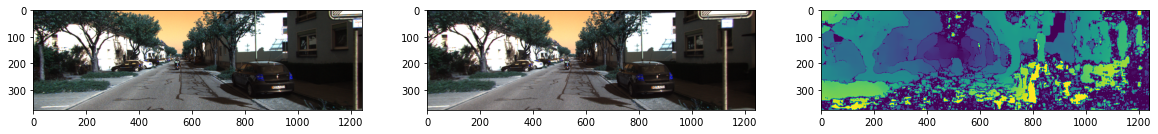

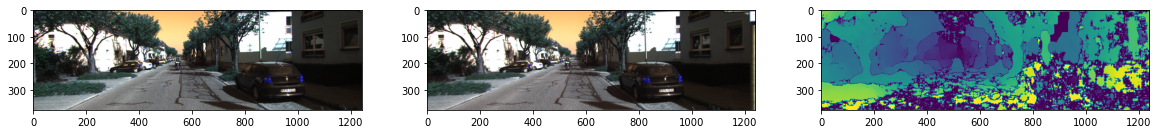

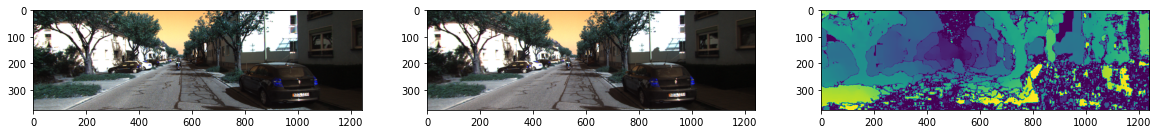

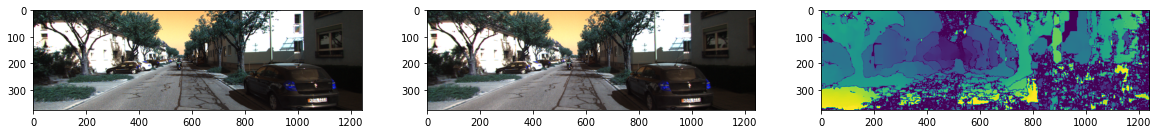

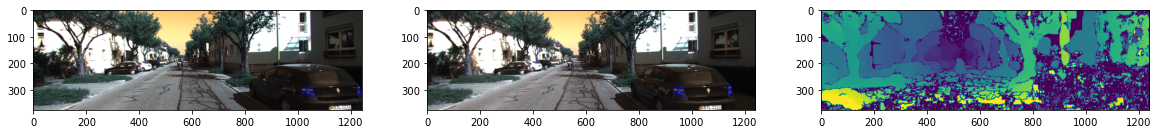

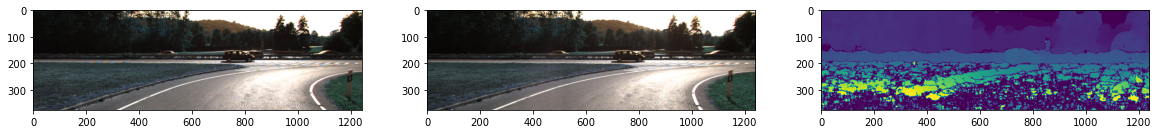

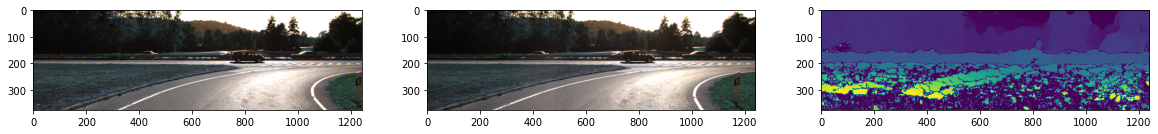

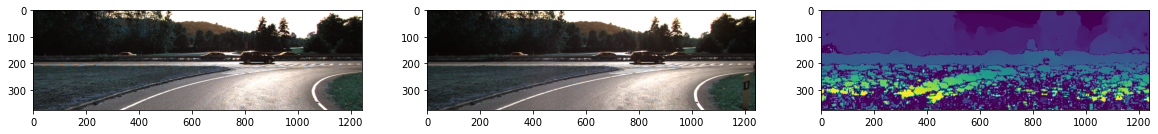

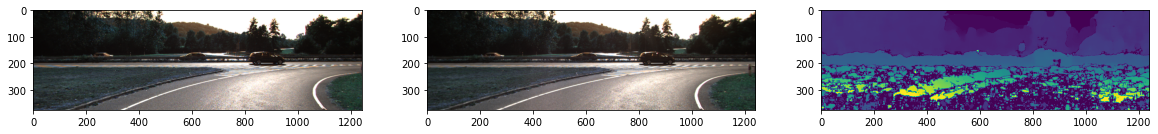

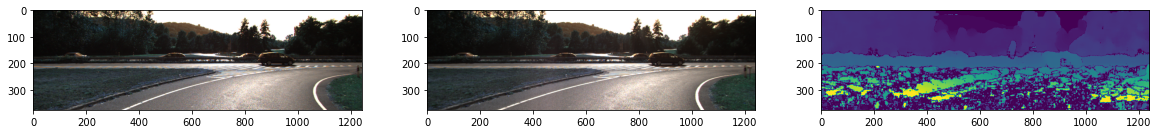

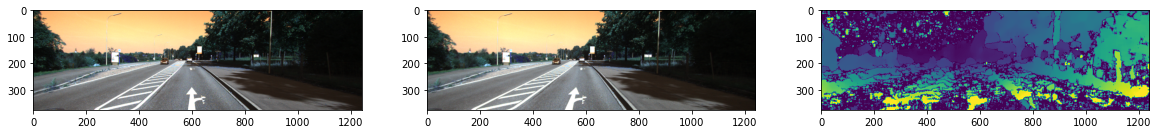

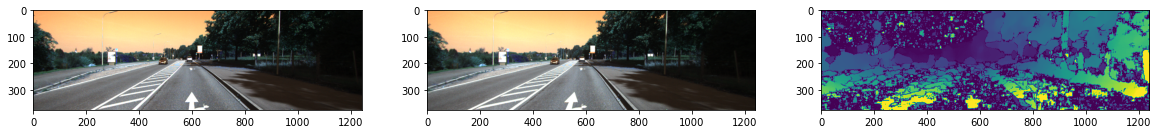

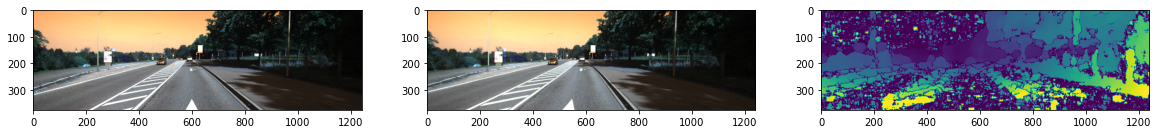

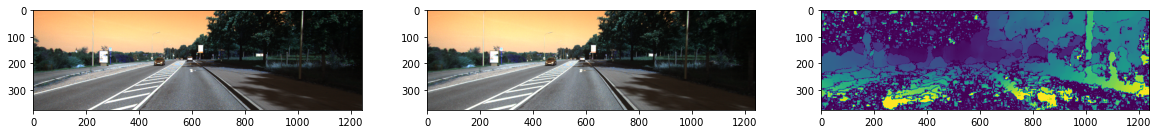

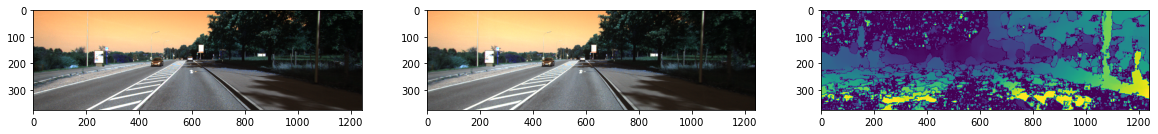

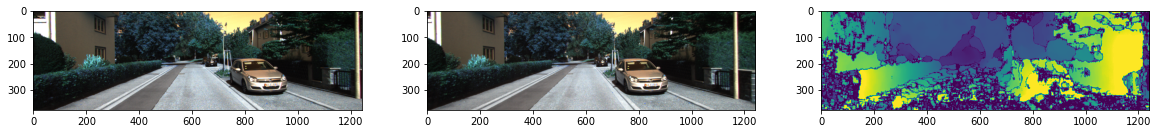

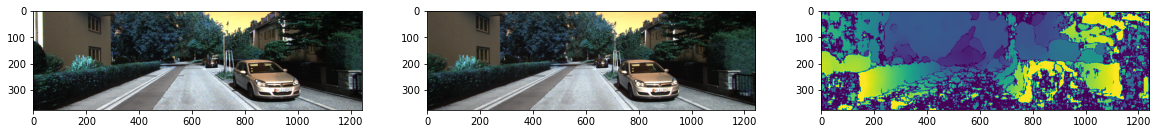

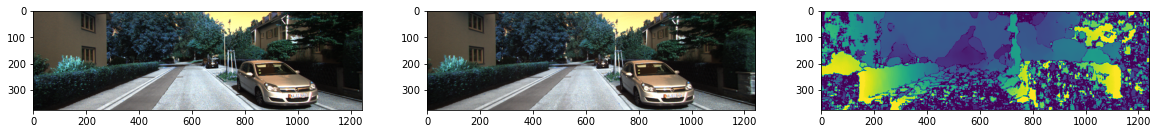

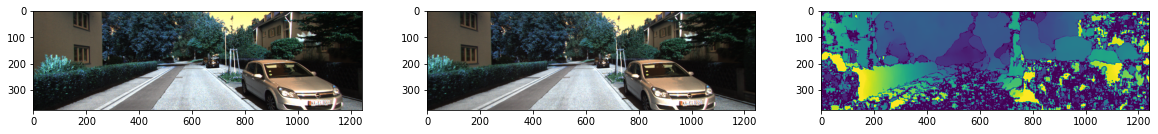

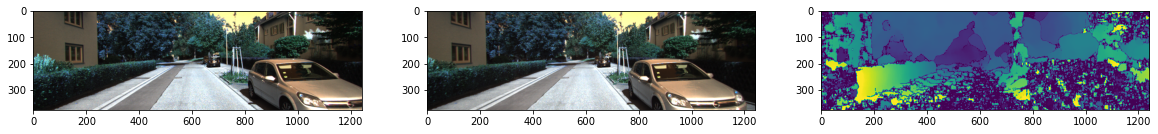

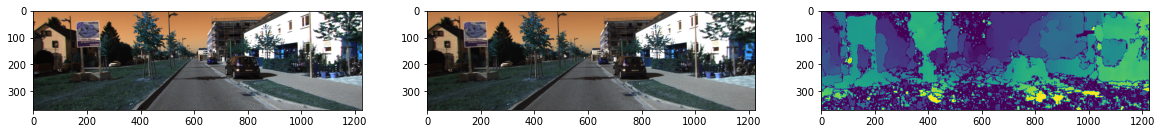

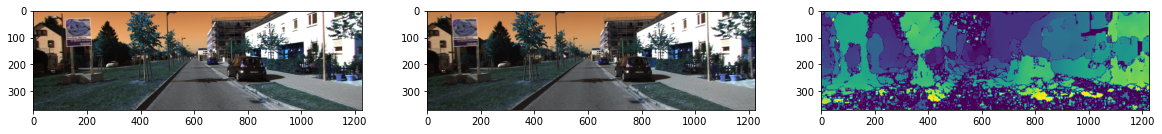

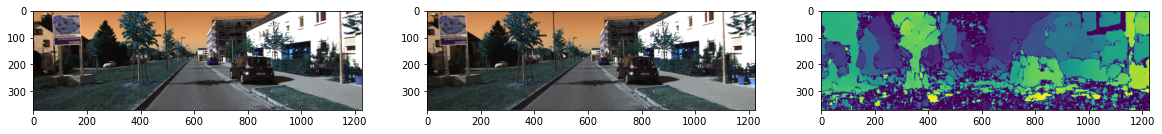

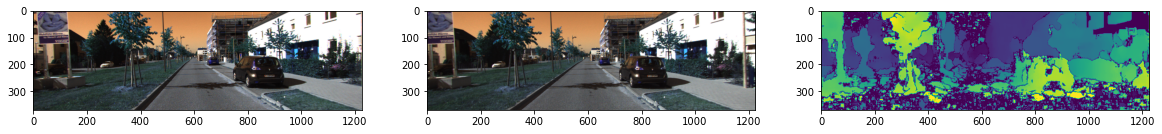

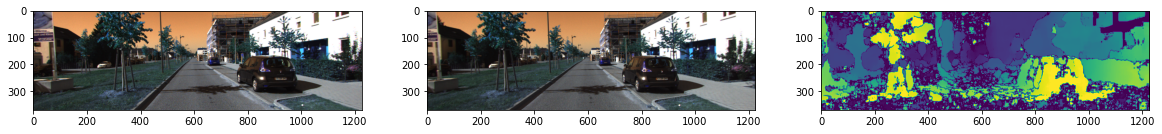

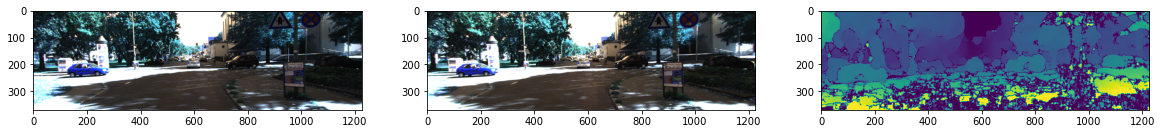

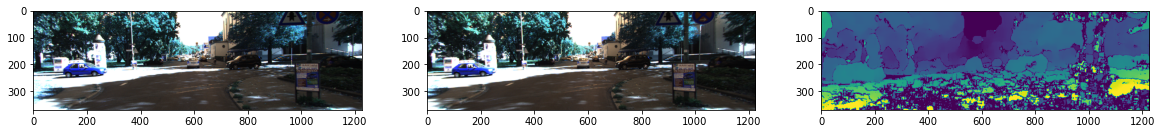

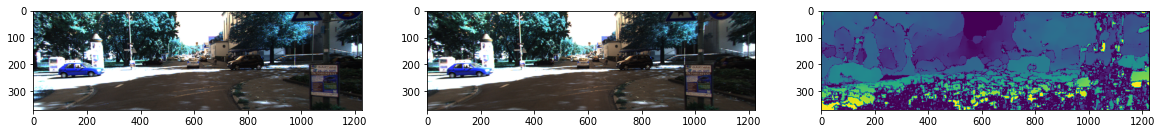

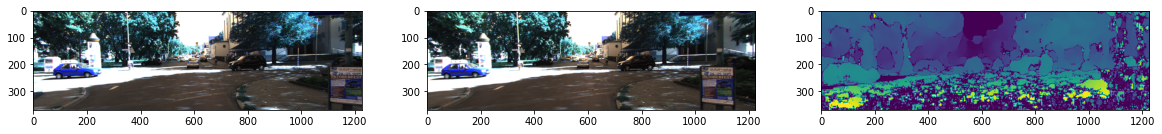

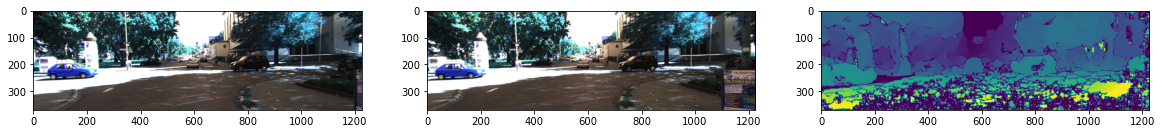

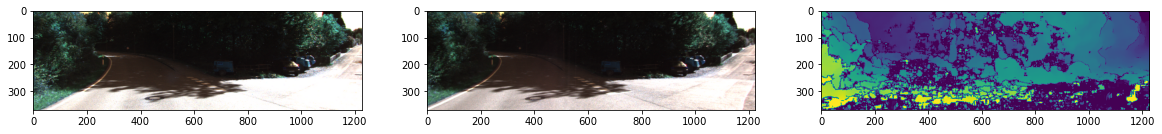

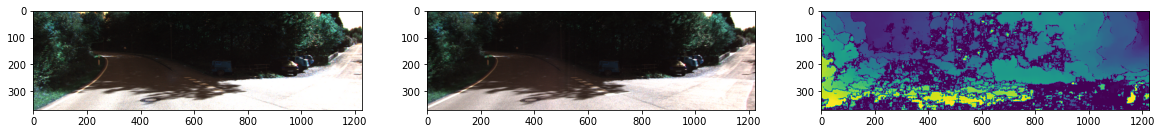

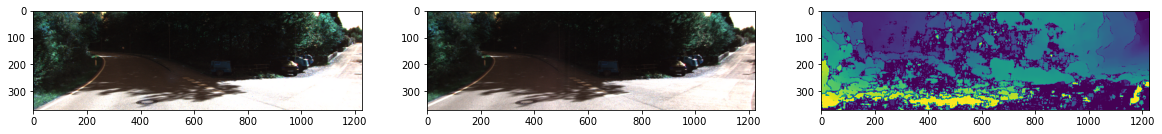

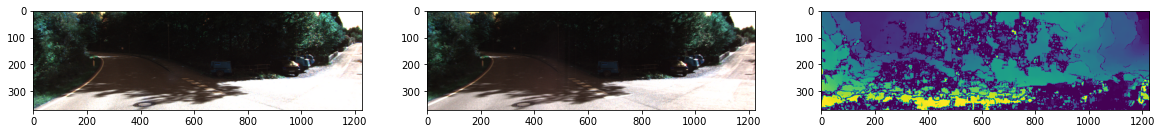

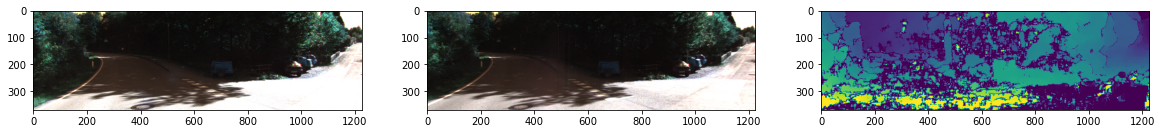

In [6]:
def test_predicted_flow(img_root,_files):
    img_root_ext='\\image_2\\*'
    X = np.arange(0, 25, 1)
    Y = np.arange(0, 25, 1)
    for i in _files:
           img_data_a=[]
           _input=np.zeros((1,image_h,image_w,6),np.float64)
           for i,path in enumerate(glob.glob(img_root+str(i).zfill(2)+img_root_ext)):
                 
                 img_a=cv2.imread(path)
                 img_b=cv2.imread(path.replace("image_2","image_3"))
                 _input[0,:,:,:3]= cv2.resize((img_a/255.0)-0.5,(image_w,image_h))
                 _input[0,:,:,3:]= cv2.resize((img_b/255.0)-0.5,(image_w,image_h))
                 #disp_1=model.predict(_input)[0][0][:,:,0]
                 disp_1=get_depth(img_a,img_b)

                 if i < 5:
                     fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
                     axes[0].imshow(img_a)
                     axes[1].imshow(img_b)
                     axes[2].imshow(disp_1)
                     plt.show()
                 else :
                    break            
    return np.array(disp_1)

_out=test_predicted_flow(img_root_test,train_files)

In [7]:
#fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(20,5))
#disp=_out[16:-16,64:-16]
#disp=cv2.resize(disp,(image_w,image_h))
#axes.imshow(disp)

In [8]:
def get_image_paths(img_root1,_files,_overlap=1):
    img_data_a=[]
    img_data_b=[]
    img_root2='\\image_2\\*'
    for i in _files:
        for path in glob.glob(img_root1+str(i).zfill(2)+img_root2)[:-1]:
            img_data_a.append([path,path.replace('image_2','image_3')])
    return np.array(img_data_a)

train_data=get_image_paths(img_root_test,train_files,_overlap=overlap)
val_data=get_image_paths(img_root_test,val_files,_overlap=overlap)
#test_data=get_image_paths(img_root,test_files,_overlap=(time_step-1))
#model.load_weights(best_wts_path)

if _gen_disp==True:
    try : os.mkdir(disp_save_root)
    except:print('dir_exists')
    for file in train_files+val_files:
        try:os.mkdir(disp_save_root+str(file).zfill(2))
        except:print(disp_save_root+str(file).zfill(2),'paths exists')

    for path in tqdm(np.concatenate([train_data,val_data])):
                _input=np.zeros((1,image_h,image_w,6),np.float64)
                img_a=cv2.resize(cv2.imread(path[0]),(image_w,image_h))
                img_b=cv2.resize(cv2.imread(path[1]),(image_w,image_h))
                #_input[0,:,:,:3]= cv2.resize((img_a/255.0)-0.5,(image_w,image_h))
                #_input[0,:,:,3:]= cv2.resize((img_b/255.0)-0.5,(image_w,image_h))
                #disp_img=model.predict(_input)[0][0]
                disp_img=get_depth(img_a,img_b)
                disp_img=cv2.resize(disp_img,(image_w//_disp_scale,image_h//_disp_scale))
                disp_path=get_disp_path(path[0])
                with open(disp_path,'wb') as file:
                     pickle.dump(disp_img,file)

  0%|                                                                                | 3/23190 [00:00<12:58, 29.78it/s]

dir_exists
D:\KITTI\data_odometry_color\dataset\_disp\00 paths exists
D:\KITTI\data_odometry_color\dataset\_disp\01 paths exists
D:\KITTI\data_odometry_color\dataset\_disp\02 paths exists
D:\KITTI\data_odometry_color\dataset\_disp\03 paths exists
D:\KITTI\data_odometry_color\dataset\_disp\06 paths exists
D:\KITTI\data_odometry_color\dataset\_disp\08 paths exists
D:\KITTI\data_odometry_color\dataset\_disp\09 paths exists
D:\KITTI\data_odometry_color\dataset\_disp\04 paths exists
D:\KITTI\data_odometry_color\dataset\_disp\05 paths exists
D:\KITTI\data_odometry_color\dataset\_disp\07 paths exists
D:\KITTI\data_odometry_color\dataset\_disp\10 paths exists


100%|████████████████████████████████████████████████████████████████████████████| 23190/23190 [12:55<00:00, 29.89it/s]


###